# Author: Bosie Akioyamen

This Module ```Model_Selection_Training``` does Modeling and Evaluation:
1. Modeling:
    - Chooses suitable machine learning algorithms for classification and detection (e.g., CNNs for image data, object detection algorithms like YOLO or SSD).
    - Train multiple models to compare their performance.
    - Fine-tune hyperparameters to improve model accuracy.
2. Evaluation:
    - Evaluate the models using appropriate metrics (e.g., accuracy, precision, recall, F1 score, mean average precision for object detection).
    - Document the modeling and evaluation process in a Jupyter Notebook.
3. Deliverables:
    - Jupyter Notebook with modeling and evaluation steps.
    - Summary of model performance and comparison for the business presentation and written report.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
import glob
from torchvision import transforms, models, datasets
from torchvision.ops import nms
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import IPython
import time
from self_driving_car_dataset import SelfDrivingCarDataset


# Checking device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define directories and read labels
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
data_dir = os.path.join(project_root, 'data')
image_dir = os.path.join(data_dir, 'downloaded_images', 'images')
label_file = os.path.join(data_dir, 'labels_train.csv')

Using device: cpu


In [2]:
print("Reading labels...")
df = pd.read_csv(label_file)
print("Initial labels dataframe loaded.")

# Preprocess labels
print("Preprocessing labels...")
df = df[df['xmin'] >= 0]
df = df[df['ymin'] >= 0]
df = df[df['xmax'] > df['xmin']]
df = df[df['ymax'] > df['ymin']]
df = df[:60000]
print("Labels preprocessing completed.")

Reading labels...
Initial labels dataframe loaded.
Preprocessing labels...
Labels preprocessing completed.


In [3]:
# Normalize bounding boxes
def new_df(df):
    print("Normalizing bounding boxes...")
    for (i, fname) in list(enumerate(df.frame.values)):
        fpath = os.path.join(image_dir, fname)
        img = np.asarray(Image.open(fpath))
        h, w, _ = img.shape
        df['xmin'].iloc[i] = df['xmin'].iloc[i] / w
        df['xmax'].iloc[i] = df['xmax'].iloc[i] / w
        df['ymin'].iloc[i] = df['ymin'].iloc[i] / h
        df['ymax'].iloc[i] = df['ymax'].iloc[i] / h
    print("Bounding boxes normalized.")
    return df

print("Calling new_df function...")
df1 = new_df(df)
print("Dataframe df1 created with normalized bounding boxes.")

Calling new_df function...
Normalizing bounding boxes...
Bounding boxes normalized.
Dataframe df1 created with normalized bounding boxes.


Filtering dataframe df1...
Number of rows in df1 after filtering: 53633
Labels defined: {0: 'background', 1: 'car', 2: 'truck', 3: 'pedestrian', 4: 'bicyclist', 5: 'light'}
Number of classes: 6


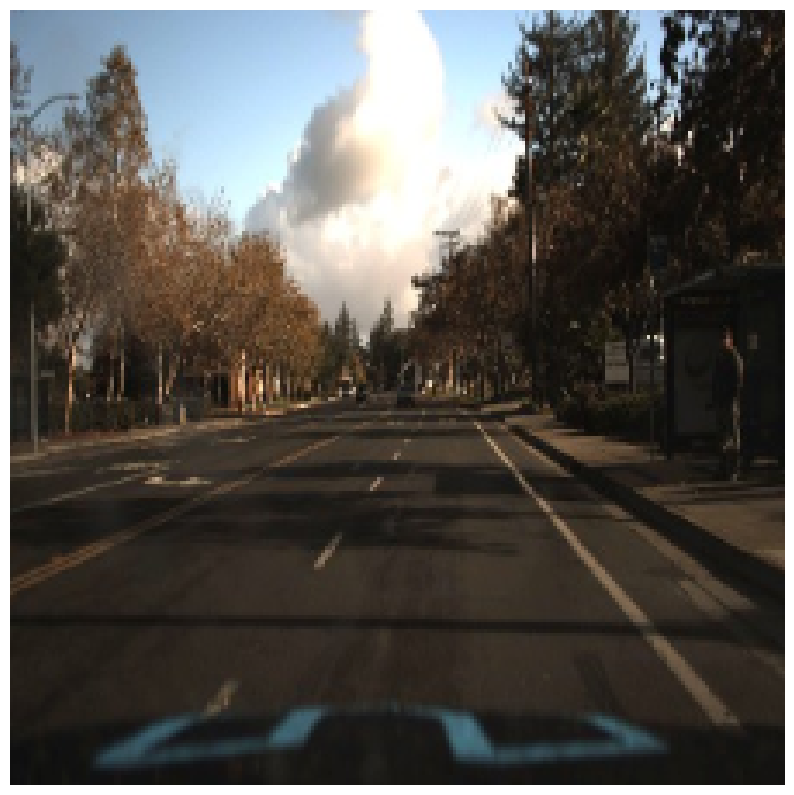

Sample image shape: (224, 224, 3)


In [4]:
# Filter dataframe
print("Filtering dataframe df1...")
df1 = df1[df1['xmin'] >= 0.1]
df1 = df1[df1['xmax'] >= 0.1]
df1 = df1[df1['ymin'] >= 0.1]
df1 = df1[df1['ymax'] >= 0.1]
print(f"Number of rows in df1 after filtering: {len(df1)}")

# Define labels
labels = {0: 'background', 1: 'car', 2: 'truck', 3: 'pedestrian', 4: 'bicyclist', 5: 'light'}
target2labels = labels.copy()
num_classes = len(labels)
print(f"Labels defined: {target2labels}")
print(f"Number of classes: {num_classes}")

# Display sample image
image_path = os.path.join(image_dir, '1478019952686311006.jpg')
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
plt.figure(figsize=(10, 13))
plt.imshow(img)
plt.axis('off')
plt.show()
print(f"Sample image shape: {img.shape}")

In [5]:
print("Splitting data into training and validation sets...")
trn_ids, val_ids = train_test_split(df1.frame.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df1[df1['frame'].isin(trn_ids)], df1[df1['frame'].isin(val_ids)]
print(f"Training set: {len(trn_df)} samples, Validation set: {len(val_df)} samples")

train_ds = SelfDrivingCarDataset(trn_df, image_dir)
val_ds = SelfDrivingCarDataset(val_df, image_dir)

# Create DataLoaders with num_workers specified
train_loader = DataLoader(train_ds, batch_size=20, collate_fn=train_ds.collate_fn, drop_last=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=20, collate_fn=val_ds.collate_fn, drop_last=True, num_workers=4)
print("Data loaders created.")

Splitting data into training and validation sets...
Training set: 48146 samples, Validation set: 5487 samples
Dataset initialized with 7538 images.
Dataset initialized with 838 images.
Data loaders created.


In [6]:
# Define model
def get_model():
    print("Loading model...")
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    print("Model loaded.")
    return model

In [7]:
def train_batch(inputs, targets, model, optimizer):
    model.train()
    inputs = list(image.to(device) for image in inputs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(inputs, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad()
def validate_batch(inputs, targets, model):
    model.eval()
    inputs = list(image.to(device) for image in inputs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    losses = model(inputs, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses


In [8]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs=1):
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss = 0.0
        print(f"Starting epoch {epoch+1}/{num_epochs}...")
        for i, (inputs, targets) in enumerate(train_loader):
            try:
                loss, _ = train_batch(inputs, targets, model, optimizer)
                train_loss += loss.item()
                if i % 10 == 0:  # Print every 10 batches
                    print(f'Batch {i}/{len(train_loader)}, Loss: {loss.item()}')
            except Exception as e:
                print(f"Error during training batch {i}: {e}")
        train_loss /= len(train_loader)

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, targets in val_loader:
                loss, _ = validate_batch(inputs, targets, model)
                val_loss += loss.item()
            val_loss /= len(val_loader)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {time.time() - start_time:.2f}s')

        # Evaluate model after each epoch
        print('Evaluation on validation set:')
        evaluate_model(model, val_loader)

    print('Training complete.')


In [9]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

def calculate_metrics(true_labels, pred_labels):
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')
    return precision, recall, f1

def get_predictions(model, data_loader):
    model.eval()
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = list(image.to(device) for image in inputs)
            outputs = model(inputs)
            for target, output in zip(targets, outputs):
                true_labels.extend(target['labels'].cpu().numpy())
                pred_labels.extend(output['labels'].cpu().numpy())
    return true_labels, pred_labels


In [10]:
def evaluate_model(model, data_loader):
    true_labels, pred_labels = get_predictions(model, data_loader)
    precision, recall, f1 = calculate_metrics(true_labels, pred_labels)
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    print("\nClassification Report:")
    print(classification_report(true_labels, pred_labels, target_names=labels.values()))

    # Example of hazard classification and severity assessment
    model.eval()
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = list(image.to(device) for image in inputs)
            outputs = model(inputs)
            for output in outputs:
                labels = output['labels'].cpu().numpy()
                boxes = output['boxes'].cpu().numpy()
                for label, box in zip(labels, boxes):
                    object_type = target2labels[label.item()]
                    bbox = [int(coord) for coord in box]
                    image_size = (224, 224)  # Assuming fixed size for this example

                    # Example usage of assess_severity
                    severity = assess_severity({
                        "type": object_type,
                        "bbox": bbox,
                        "image_size": image_size
                    })
                    
                    # Example usage of classify_hazard
                    hazard_classification = classify_hazard(object_type)
                    
                    print(f'Object: {object_type}, Hazard Classification: {hazard_classification}, Severity: {severity}')

                    # You can store or further process the hazard classifications and severity assessments as needed


In [11]:
def classify_hazard(object_type):
    hazardous_objects = ['car', 'truck', 'pedestrian']
    return 'hazardous' if object_type in hazardous_objects else 'non-hazardous'

def assess_severity(object_info):
    bbox = object_info['bbox']
    image_size = object_info['image_size']
    object_type = object_info['type']

    # Calculate the center of the bounding box
    bbox_center_x = (bbox[0] + bbox[2]) / 2
    bbox_center_y = (bbox[1] + bbox[3]) / 2

    # Calculate the distance from the center of the image to the center of the bounding box
    image_center_x = image_size[0] / 2
    image_center_y = image_size[1] / 2
    distance_to_center = ((bbox_center_x - image_center_x) ** 2 + (bbox_center_y - image_center_y) ** 2) ** 0.5

    # Calculate the area of the bounding box
    bbox_area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])

    # Normalize distance and area
    normalized_distance = distance_to_center / ((image_size[0] ** 2 + image_size[1] ** 2) ** 0.5)
    normalized_area = bbox_area / (image_size[0] * image_size[1])

    # Define thresholds for severity
    distance_threshold = 0.5  # Adjusted to consider objects further from the center
    area_threshold = 0.05

    if normalized_distance < distance_threshold and normalized_area > area_threshold:
        severity = 'high'
    elif normalized_distance < distance_threshold or normalized_area > area_threshold:
        severity = 'medium'
    else:
        severity = 'low'

    return severity

# Example usage
object_info = {
    "type": "car",
    "bbox": [50, 50, 150, 150],  # Near the top-left corner
    "image_size": [800, 600]
}

print(classify_hazard(object_info['type']))  # Output: 'hazardous'
print(assess_severity(object_info))          # Output: 'medium' (for example)

hazardous
medium


In [ ]:
# Train model
num_epochs = 1
print(f'Starting training for {num_epochs} epochs...')
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
train_model(model, train_loader, val_loader, optimizer, num_epochs=num_epochs)

# Evaluate model
print('Final evaluation on validation set:')
evaluate_model(model, val_loader)

print('Training and evaluation complete.')


Starting training for 1 epochs...
Loading model...
Model loaded.
Starting epoch 1/1...
Batch 0/471, Loss: 1.9600341320037842
